In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
# from src.backup import CrossSpeciesVAE
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_, gene_ids = pickle.load(open('species_tsvd_gene_embeddings.pkl','rb'))
# gene_embeddings={k: torch.tensor(v) for k,v in gene_embeddings.items()}
homology_edges, homology_scores = pickle.load(open('species_homology_info.pkl','rb'))

adata1 = adata1[:,gene_ids[0]].copy()
adata2 = adata2[:,gene_ids[1]].copy()
adata3 = adata3[:,gene_ids[2]].copy()

batch_size = 256
species_data = {
    "planarian": adata1,
    "schisto": adata2,
    "hydra": adata3,
}

data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=1.0,
    init_beta=1e-3,
    final_beta=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    homology_weight=1.0,
)

early_stopping = StageAwareEarlyStopping(
    monitor='val_recon',
    min_delta=0.0,
    patience=10,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=100,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_homology",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=False,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

In [ ]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon", "kl", "homology"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

# Saving
save_dict = {
    'state_dict': model.state_dict(),
    'hyper_parameters': model.hparams,
    'epoch': 99,
}
torch.save(save_dict, f'manual_checkpoint_epoch_{99}.pt')

In [ ]:

output, s = model.get_latent_embeddings(species_data)
s=s.cpu().numpy()

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [ ]:
from scipy.stats import spearmanr

for i, adata in enumerate([adata1, adata2, adata3]):
    x = model.encoders[str(i)].gene_importance(torch.tensor(adata.X.toarray()).to('cuda')).detach().cpu().numpy()
    mu = x.mean(0)
    mu[mu==0]=1
    a = x.var(0)/mu
    b = adata.var['weights'].values

    # plt.figure(); plt.scatter(a,b,s=1);
    # plt.figure(); plt.scatter(x.var(0),adata.X.toarray().var(0),s=1);    
    print(i)
    print('pearson',np.corrcoef(a,b)[0,1])
    print('spearman',spearmanr(a,b).statistic)


In [ ]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

x=[]
y=[]
for i in range(len(set(s))):
    for j in range(i+1,len(set(s))):
        x.extend(homology_scores[i][j]/homology_scores[i][j].max())
        x.extend(homology_scores[j][i]/homology_scores[j][i].max())        
        y.extend(list(sigmoid(model.homology_scores[str(i)][str(j)].detach().cpu().numpy())))
        y.extend(list(sigmoid(model.homology_scores[str(j)][str(i)].detach().cpu().numpy())))
x=np.array(x)
y=np.array(y)
plt.figure(); plt.scatter(x,y,s=0.5);

# SCVI

In [14]:
from src.scvi import SCVINetwork

# Loading
checkpoint = torch.load('manual_checkpoint_epoch_99.pt')
model = CrossSpeciesVAE(
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    **checkpoint['hyper_parameters']
)
model.load_state_dict(checkpoint['state_dict'])
model.eval();  # if using for inference

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=10,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=100,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_loss",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

scvi = SCVINetwork(
    cross_species_vae=model,
    n_hidden = 128,
    n_latent = 64,
    n_layers = 1,
    dropout_rate = 0.2,
    learning_rate = 1e-4,
    min_learning_rate = 1e-6,
    warmup_epochs = 1.0,
    init_beta = 1e-3,  
    final_beta = 0.1,
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",    
)

/tmp/ipykernel_504339/3934040060.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('manual_checkpoint_epoch_99.pt')
Using 16bit Automatic Mixed Pre

In [15]:
trainer.fit(scvi, data_module)

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                 | Params | Mode 
-------------------------------------------------------------------
0 | cross_species_vae | CrossSpeciesVAE      | 26.1 M | eval 
1 | gene_importance   | GeneImportanceModule | 10.0 M | train
2 | encoder           | DeepInjectionEncoder | 5.0 M  | train
3 | decoder           | DeepInjectionDecoder | 5.0 M  | train
  | other params      | n/a                  | 38.5 K | n/a  
-------------------------------------------------------------------
20.0 M    Trainable params
26.1 M    Non-trainable params
46.1 M    Total params
184.311   Total estimated model params size (MB)
28        Modules in train mode
93        Mo

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wo

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 35.39it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 29.25it/s, v_num=239]   

Metric val_loss improved. New best score: 0.909


Epoch 1: 100%|██████████| 12/12 [00:00<00:00, 35.53it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:00<00:00, 29.36it/s, v_num=239]   

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.889


Epoch 2: 100%|██████████| 12/12 [00:00<00:00, 35.68it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:00<00:00, 29.44it/s, v_num=239]   

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.859


Epoch 3: 100%|██████████| 12/12 [00:00<00:00, 34.27it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:00<00:00, 28.40it/s, v_num=239]   

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.832


Epoch 4: 100%|██████████| 12/12 [00:00<00:00, 35.88it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:00<00:00, 29.40it/s, v_num=239]   

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.811


Epoch 5: 100%|██████████| 12/12 [00:00<00:00, 35.47it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 12/12 [00:00<00:00, 29.27it/s, v_num=239]   

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.748


Epoch 6: 100%|██████████| 12/12 [00:00<00:00, 35.75it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 12/12 [00:00<00:00, 29.45it/s, v_num=239]   

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.717


Epoch 7: 100%|██████████| 12/12 [00:00<00:00, 36.01it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 12/12 [00:00<00:00, 29.65it/s, v_num=239]   

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.680


Epoch 8: 100%|██████████| 12/12 [00:00<00:00, 36.08it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 12/12 [00:00<00:00, 29.51it/s, v_num=239]   

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.654


Epoch 9: 100%|██████████| 12/12 [00:00<00:00, 34.58it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 12/12 [00:00<00:00, 28.49it/s, v_num=239]   

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.605


Epoch 10: 100%|██████████| 12/12 [00:00<00:00, 34.64it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 12/12 [00:00<00:00, 28.74it/s, v_num=239]  

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.592


Epoch 11: 100%|██████████| 12/12 [00:00<00:00, 35.59it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 12/12 [00:00<00:00, 29.37it/s, v_num=239]  

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.566


Epoch 12: 100%|██████████| 12/12 [00:00<00:00, 35.80it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 12/12 [00:00<00:00, 29.56it/s, v_num=239]  

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.557


Epoch 13: 100%|██████████| 12/12 [00:00<00:00, 35.94it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 12/12 [00:00<00:00, 29.60it/s, v_num=239]  

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.526


Epoch 14: 100%|██████████| 12/12 [00:00<00:00, 35.77it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 12/12 [00:00<00:00, 29.34it/s, v_num=239]  

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.507


Epoch 15: 100%|██████████| 12/12 [00:00<00:00, 35.82it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 12/12 [00:00<00:00, 29.57it/s, v_num=239]  

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.499


Epoch 16: 100%|██████████| 12/12 [00:00<00:00, 36.09it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 12/12 [00:00<00:00, 29.74it/s, v_num=239]  

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.475


Epoch 17: 100%|██████████| 12/12 [00:00<00:00, 36.09it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 12/12 [00:00<00:00, 29.74it/s, v_num=239]  

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.456


Epoch 18: 100%|██████████| 12/12 [00:00<00:00, 36.05it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 12/12 [00:00<00:00, 29.65it/s, v_num=239]  

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.447


Epoch 19: 100%|██████████| 12/12 [00:00<00:00, 35.77it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 12/12 [00:00<00:00, 29.34it/s, v_num=239]  

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.443


Epoch 20: 100%|██████████| 12/12 [00:00<00:00, 35.70it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 12/12 [00:00<00:00, 29.43it/s, v_num=239]  

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.431


Epoch 21: 100%|██████████| 12/12 [00:00<00:00, 36.12it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 12/12 [00:00<00:00, 29.77it/s, v_num=239]  

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.420


Epoch 22: 100%|██████████| 12/12 [00:00<00:00, 36.09it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 12/12 [00:00<00:00, 29.76it/s, v_num=239]  

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.410


Epoch 23: 100%|██████████| 12/12 [00:00<00:00, 36.10it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 12/12 [00:00<00:00, 29.78it/s, v_num=239]  

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.406


Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 36.12it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 12/12 [00:00<00:00, 29.36it/s, v_num=239]  

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.398


Epoch 25: 100%|██████████| 12/12 [00:00<00:00, 35.54it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 12/12 [00:00<00:00, 29.32it/s, v_num=239]  

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.389


Epoch 26: 100%|██████████| 12/12 [00:00<00:00, 35.38it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 12/12 [00:00<00:00, 29.25it/s, v_num=239]  

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.379


Epoch 27: 100%|██████████| 12/12 [00:00<00:00, 35.45it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 12/12 [00:00<00:00, 35.93it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 12/12 [00:00<00:00, 29.56it/s, v_num=239]  

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.366


Epoch 29: 100%|██████████| 12/12 [00:00<00:00, 35.19it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 12/12 [00:00<00:00, 35.29it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 12/12 [00:00<00:00, 35.46it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 12/12 [00:00<00:00, 29.33it/s, v_num=239]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.364


Epoch 32: 100%|██████████| 12/12 [00:00<00:00, 35.53it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 12/12 [00:00<00:00, 29.35it/s, v_num=239]  

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.354


Epoch 33: 100%|██████████| 12/12 [00:00<00:00, 36.06it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 12/12 [00:00<00:00, 36.01it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 12/12 [00:00<00:00, 29.49it/s, v_num=239]  

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.347


Epoch 35: 100%|██████████| 12/12 [00:00<00:00, 35.83it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 12/12 [00:00<00:00, 29.56it/s, v_num=239]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.345


Epoch 36: 100%|██████████| 12/12 [00:00<00:00, 36.06it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 12/12 [00:00<00:00, 35.72it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 12/12 [00:00<00:00, 35.97it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 12/12 [00:00<00:00, 35.98it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 12/12 [00:00<00:00, 29.49it/s, v_num=239]  

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.339


Epoch 40: 100%|██████████| 12/12 [00:00<00:00, 35.37it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 12/12 [00:00<00:00, 29.22it/s, v_num=239]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.336


Epoch 41: 100%|██████████| 12/12 [00:00<00:00, 34.92it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 12/12 [00:00<00:00, 35.06it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 12/12 [00:00<00:00, 28.97it/s, v_num=239]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.333


Epoch 43: 100%|██████████| 12/12 [00:00<00:00, 35.83it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 12/12 [00:00<00:00, 36.07it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 12/12 [00:00<00:00, 29.56it/s, v_num=239]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.333


Epoch 45: 100%|██████████| 12/12 [00:00<00:00, 35.81it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████| 12/12 [00:00<00:00, 29.54it/s, v_num=239]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.330


Epoch 46: 100%|██████████| 12/12 [00:00<00:00, 35.70it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████| 12/12 [00:00<00:00, 34.66it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████| 12/12 [00:00<00:00, 28.75it/s, v_num=239]  

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.322


Epoch 48: 100%|██████████| 12/12 [00:00<00:00, 35.54it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 12/12 [00:00<00:00, 35.73it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 12/12 [00:00<00:00, 29.31it/s, v_num=239]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.318


Epoch 50: 100%|██████████| 12/12 [00:00<00:00, 35.01it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████| 12/12 [00:00<00:00, 35.69it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████| 12/12 [00:00<00:00, 34.14it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████| 12/12 [00:00<00:00, 34.50it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████| 12/12 [00:00<00:00, 28.69it/s, v_num=239]  

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.312


Epoch 54: 100%|██████████| 12/12 [00:00<00:00, 35.99it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|██████████| 12/12 [00:00<00:00, 36.07it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 12/12 [00:00<00:00, 35.97it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████| 12/12 [00:00<00:00, 36.05it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 12/12 [00:00<00:00, 36.08it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 12/12 [00:00<00:00, 36.01it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████| 12/12 [00:00<00:00, 35.88it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████| 12/12 [00:00<00:00, 35.19it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|██████████| 12/12 [00:00<00:00, 36.08it/s, v_num=23

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.303


Epoch 63: 100%|██████████| 12/12 [00:00<00:00, 35.87it/s, v_num=239]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|██████████| 12/12 [00:00<00:00, 35.96it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████| 12/12 [00:00<00:00, 35.75it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|██████████| 12/12 [00:00<00:00, 35.93it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████| 12/12 [00:00<00:00, 35.70it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████| 12/12 [00:00<00:00, 35.91it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████| 12/12 [00:00<00:00, 36.14it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 70: 100%|██████████| 12/12 [00:00<00:00, 34.70it/s, v_num=239]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████| 12/12 [00:00<00:00, 32.74it/s, v_num=23

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.303. Signaling Trainer to stop.


Epoch 72: 100%|██████████| 12/12 [00:00<00:00, 28.72it/s, v_num=239]


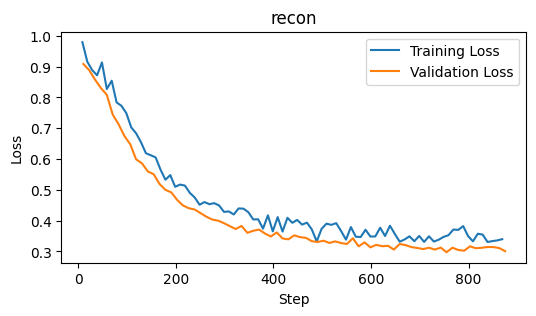

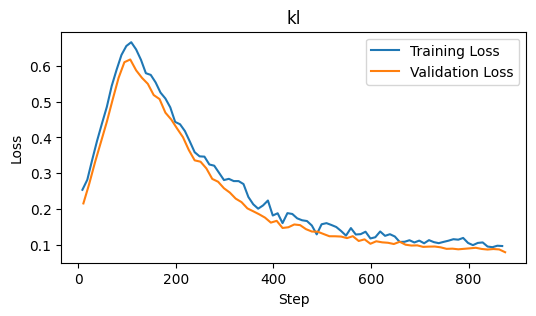

In [16]:
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon", "kl"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

0.4379069571170492
0.30349209055559656
0.40336864010454043


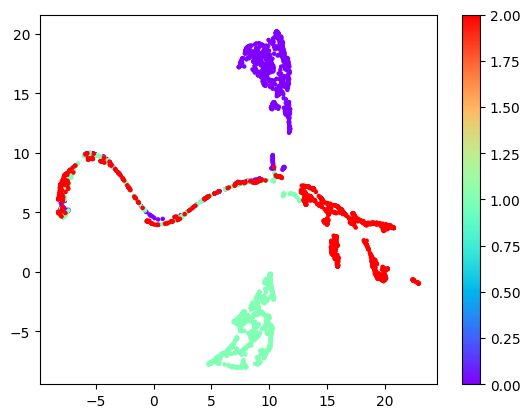

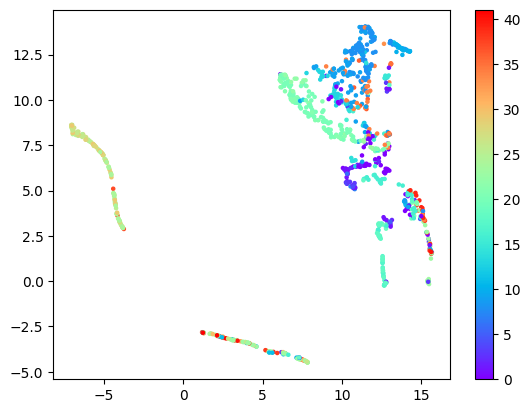

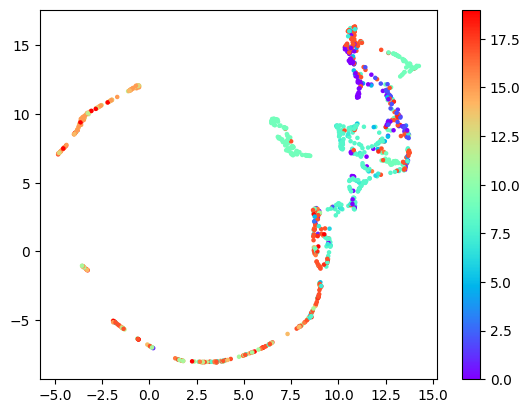

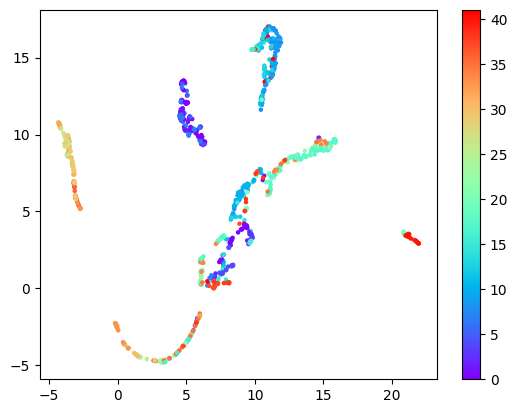

In [17]:

output = scvi.get_latent_embeddings(species_data)

s = np.array(sum([[i]*len(adata) for i, adata in enumerate([adata1, adata2, adata3])],[]))

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [20]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

# adata.write_h5ad('test.h5ad')

In [21]:
import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

2024-12-02 17:39:46,696 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-02 17:39:46,886 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-02 17:39:46,891 - harmonypy - INFO - Iteration 1 of 10
2024-12-02 17:39:47,050 - harmonypy - INFO - Iteration 2 of 10
2024-12-02 17:39:47,202 - harmonypy - INFO - Iteration 3 of 10
2024-12-02 17:39:47,356 - harmonypy - INFO - Iteration 4 of 10
2024-12-02 17:39:47,507 - harmonypy - INFO - Iteration 5 of 10
2024-12-02 17:39:47,659 - harmonypy - INFO - Iteration 6 of 10
2024-12-02 17:39:47,811 - harmonypy - INFO - Iteration 7 of 10
2024-12-02 17:39:47,966 - harmonypy - INFO - Iteration 8 of 10
2024-12-02 17:39:48,116 - harmonypy - INFO - Iteration 9 of 10
2024-12-02 17:39:48,268 - harmonypy - INFO - Iteration 10 of 10
2024-12-02 17:39:48,417 - harmonypy - INFO - Stopped before convergence


In [22]:
adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

In [24]:
adata.write_h5ad('test.h5ad')

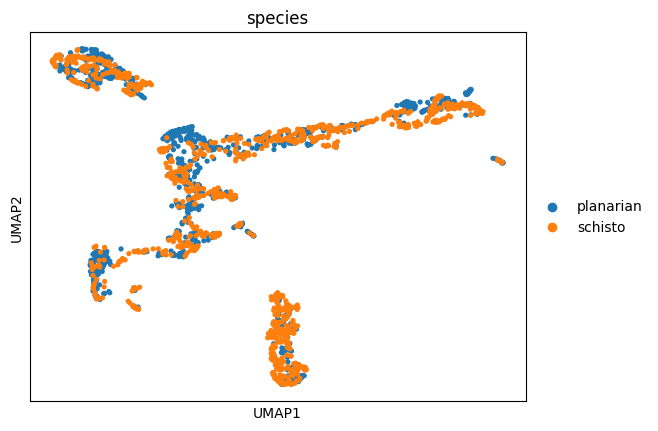

In [23]:
sc.pl.umap(adata, color ='species')

In [20]:
np.argsort(-model.homology_scores['0']['1'].detach().cpu().numpy())

array([ 71389,      0,  62378, ...,  82299,   6656, 108745])

In [23]:
adata1.var_names[7921]

'dd_Smed_v4_2215_0_1'

In [29]:
adata2.var_names[3749]

'Smp_135560'

In [28]:
homology_scores[0][1][[71389,0]]

tensor([5, 5])

In [21]:
homology_edges[0][1][[71389,0]]

tensor([[7921, 3749],
        [   0, 1232]], dtype=torch.int32)

In [10]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [11]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [19]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))

A = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
B = c2[indices]

In [26]:
a,c = np.unique(A + '--' + B,return_counts=True)
a[np.argsort(-c)]

array(['Neural--Neural', 'Neoblast--Cathepsin',
       'Epidermal--Tegument_prog', 'Epidermal--Cathepsin',
       'Epidermal--Neoblast', 'Cathepsin+ cells--Cathepsin',
       'Neoblast--Intestine', 'Neural--Parenchymal',
       'Cathepsin+ cells--Neural_KK7', 'Cathepsin+ cells--Neural',
       'Intestine--Cathepsin', 'Muscle--Parenchymal', 'Neural--Neoblast',
       'Muscle--Neural_KK7', 'Cathepsin+ cells--Parenchymal',
       'Neoblast--Muscle', 'Muscle--Neoblast', 'Neural--Muscle',
       'Pharynx--Neural', 'Muscle--Intestine', 'Neural--Flame cells',
       'Cathepsin+ cells--Intestine', 'Parapharyngeal--Muscle',
       'Intestine--Intestine', 'Neoblast--Neoblast', 'Neural--Cathepsin',
       'Protonephridia--Neural', 'Parapharyngeal--Neoblast',
       'Epidermal--Tegument', 'Muscle--Neural', 'Epidermal--Muscle',
       'Epidermal--Neural', 'Protonephridia--Cathepsin', 'Muscle--Gland',
       'Epidermal--Intestine', 'Intestine--Muscle',
       'Intestine--Tegument_prog', 'Neural--Int

In [23]:
pd.DataFrame(B[:20])

,0,1,2,3,4
0,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
1,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
2,Muscle,Intestine,Cathepsin,Cathepsin,Cathepsin
3,Cathepsin,Neoblast,Tegument_prog,Neoblast,Tegument_prog
4,Muscle,Cathepsin,Intestine,Cathepsin,Intestine
5,Muscle,Intestine,Muscle,Neural,Cathepsin
6,Cathepsin,Intestine,Cathepsin,Cathepsin,Parenchymal
7,Muscle,Neoblast,Parenchymal,Cathepsin,Neural
8,Cathepsin,Cathepsin,Intestine,Cathepsin,Cathepsin
9,Neural_KK7,Cathepsin,Gland,Neural_KK7,Parenchymal


In [15]:
B.shape

(1049, 5)

In [41]:
A1 = A[:1049].copy()
A1[i1 < 1049] = "nan"

B1 = B[:1049].copy()
B1[i1 < 1049] = "nan"

B1[:,0] = B[:1049,0]

In [46]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [43]:
pd.DataFrame(B1[(B1[:,1:]=='nan').sum(1) < 4])

,0,1,2,3,4
0,Neural: 1,nan,nan,nan,Neural: 23
1,Pharynx: 25,nan,nan,nan,Parapharyngeal: 12
2,Parapharyngeal: 12,nan,Parapharyngeal: 12,Parapharyngeal: 12,Neoblast: 0
3,Neural: 1,nan,Parapharyngeal: 12,i_smgc1,nan
4,Protonephridia: 26,Neoblast: 0,Neoblast: 0,Neoblast: 0,nan
5,Neural: 9,nan,nan,nan,Neural: 20
6,Neural: 9,nan,nan,nan,Neural: 23
7,Neoblast: 5,Muscle: 14,Muscle: 14,Muscle: 14,Muscle: 14
8,Parapharyngeal: 12,nan,nan,Parapharyngeal: 12,Muscle: 14
9,Neural: 36,nan,nan,enEp_head,nan


In [ ]:
A1

In [34]:
B1

array([['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Neoblast', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['Epidermal', 'Neural', 'Neural', 'Parenchymal', 'Neural'],
       ['Neural', 'nan', 'nan', 'nan', 'nan'],
       ['Neural', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [28]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [27]:
A1

array([['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [37]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [38]:
c2[:20]

array([['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Neural', 'Muscle', 'Parenchymal', 'Neoblast', 'Neural'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Tegument_prog', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Parenchymal', 'Neural', 'Neoblast', 'Neoblast', 'Intestine'],
       ['Ne